# Image Classification using Convolutional Neural Network

In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os 
import torch 
import torchvision 
import tarfile

from torchvision.datasets import CIFAR10
from torch.utils import data

import torch.nn as nn
import torch.nn.functional as F

In [38]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
torchvision.datasets.utils.download_url(url=dataset_url, root='~/Developer/GITHUB/DATA')

Using downloaded and verified file: /Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10.tgz


In [39]:
# Extract from archive 
if os.path.isdir('/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10')==False:
    with tarfile.open('/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10.tgz') as tar:
        tar.extractall(path = '/Users/shriharimuttagi/Developer/GITHUB/DATA')

In [40]:
paths = '/Users/shriharimuttagi/Developer/GITHUB/DATA/cifar10'
print(os.listdir(paths))

classes = os.listdir(paths+'/train')
print(classes)

print('Images per label =',len(os.listdir(paths+'/train/bird')))

['.DS_Store', 'test', 'labels.txt', 'train']
['cat', 'dog', 'truck', 'bird', 'airplane', 'ship', 'frog', 'horse', 'deer', 'automobile']
Images per label = 5000


In [41]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Batching the Data

#### Image is RGB (3,x,x)

In [42]:
train_dataset = torchvision.datasets.ImageFolder(paths+'/train', transform=torchvision.transforms.ToTensor())

print('Total images in Training = ',len(train_dataset))

img, label = train_dataset[2]
print('Image shape = {} and Label of image = {}'.format(img.shape, label))

# labeled data
print('labels are = ', train_dataset.classes)

Total images in Training =  50000
Image shape = torch.Size([3, 32, 32]) and Label of image = 0
labels are =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [43]:
test_dataset = torchvision.datasets.ImageFolder(paths+'/test', transform=torchvision.transforms.ToTensor())

print('Total images in Training = ',len(test_dataset))

img, label = train_dataset[2]
print('Image shape = {} and Label of image = {}'.format(img.shape, label))

# labeled data
print('labels are = ', test_dataset.classes)

Total images in Training =  10000
Image shape = torch.Size([3, 32, 32]) and Label of image = 0
labels are =  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


#### Initilize the Batch Data & create Validation set
Validation set = 5000
training data = 4500

In [44]:
batch_size = 100
val = 0
train_size = len(train_dataset)-val

torch.manual_seed(76)

In [45]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val])

print('Training set = {} and Validation Set = {}'.format(len(train_set), len(val_set)))

Training set = 50000 and Validation Set = 0


#### Randomize Training and validation data

In [46]:
train_set = data.dataloader.DataLoader(train_set,batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_set = data.dataloader.DataLoader(val_set, batch_size=batch_size, num_workers=4, pin_memory=True)



In [47]:
# TEST DATALOADER
test_set = data.dataloader.DataLoader(test_dataset,batch_size=batch_size)

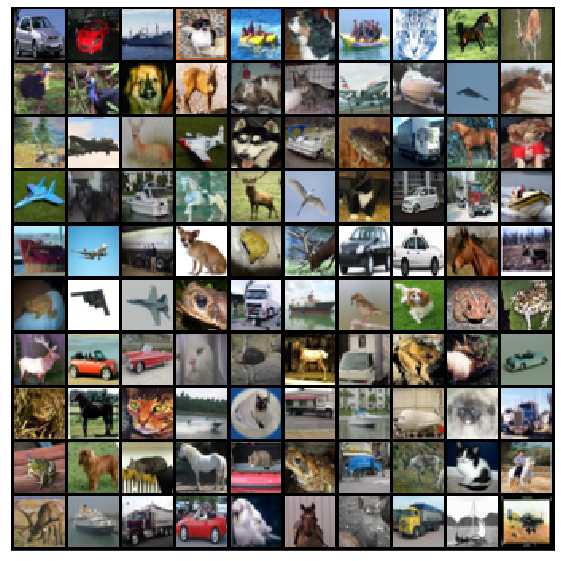

In [12]:
# matplotlib works as (img.hight, img.wight, channels)
# therefore we have to convert (3,x,x) to --> (x,x,3)

def show_batch(batch_imgs):
    for img, label in batch_imgs:
        fig, ax = plt.subplots(figsize = (10,10))
        ax.imshow(torchvision.utils.make_grid(img, nrow=10).permute(1,2,0))
        ax.set_xticks([]), ax.set_yticks([])
        break

show_batch(train_set)

# Define MODEL

INPUT IMAGE ==> CONV LAYER ==> POOLING LAYER ==> CONV LAYER ==> POOLING LAYER ==> FULLY CONNECTED LAYER

In [13]:
# Simple network
simple_model = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2)
max_pool = nn.MaxPool2d(2,2)

for images, labels in train_set:
    print('images shape = ', images.shape)
    out = simple_model(images)
    print('Convolution layer output shape = ', out.shape)
    out1 = max_pool(out)
    print('Max_Pooling shape = ', out1.shape)
    break
    
# ## change kernel_size, stride, padding

images shape =  torch.Size([100, 3, 32, 32])
Convolution layer output shape =  torch.Size([100, 64, 34, 34])
Max_Pooling shape =  torch.Size([100, 64, 17, 17])


# Train the Model

### Fit the Model and Evaluate
model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.



In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [48]:
num_epochs = 12
learning_rate = 0.001

# itr_train = ((len(train_dataset)/batch_size)/200)*num_epochs
xx = ((len(train_dataset)/batch_size)/(30/num_epochs))
# itr_test = (len(test_dataset)/batch_size)/4
yy = int((len(test_dataset)/batch_size)/30)

print(xx,yy, batch_size)

200.0 3 100


In [16]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Sequential(nn.Linear(128*3*3, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 512),
                                nn.ReLU(),
                                nn.Linear(512, 10))
        
    def forward(self, x):
        out = self.layer1(x)
        #print(out.shape)
        out = self.layer2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)
        #print(out.shape)
        out = self.fc(out)
        return out

model = ConvNet().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_set)
acc = []
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_set):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % xx == 0:
            a = accuracy(outputs, labels)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}, Accuracy: {:.2f}%'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), a*100))
            
            acc.append(a)
            losses.append(loss.detach())
        
        


Epoch [1/12], Step [200/500], Loss: 1.02, Accuracy: 67.00%
Epoch [1/12], Step [400/500], Loss: 1.14, Accuracy: 57.00%
Epoch [2/12], Step [200/500], Loss: 0.78, Accuracy: 73.00%
Epoch [2/12], Step [400/500], Loss: 0.94, Accuracy: 72.00%
Epoch [3/12], Step [200/500], Loss: 0.85, Accuracy: 67.00%
Epoch [3/12], Step [400/500], Loss: 0.70, Accuracy: 78.00%
Epoch [4/12], Step [200/500], Loss: 0.70, Accuracy: 77.00%
Epoch [4/12], Step [400/500], Loss: 0.55, Accuracy: 79.00%
Epoch [5/12], Step [200/500], Loss: 0.50, Accuracy: 79.00%
Epoch [5/12], Step [400/500], Loss: 0.47, Accuracy: 86.00%
Epoch [6/12], Step [200/500], Loss: 0.35, Accuracy: 86.00%
Epoch [6/12], Step [400/500], Loss: 0.47, Accuracy: 84.00%
Epoch [7/12], Step [200/500], Loss: 0.41, Accuracy: 84.00%
Epoch [7/12], Step [400/500], Loss: 0.32, Accuracy: 92.00%
Epoch [8/12], Step [200/500], Loss: 0.24, Accuracy: 90.00%
Epoch [8/12], Step [400/500], Loss: 0.32, Accuracy: 89.00%
Epoch [9/12], Step [200/500], Loss: 0.15, Accuracy: 95.0

In [17]:
def plot_accuracies(accuracy):
    accuracies = [x for x in accuracy]
    plt.plot(accuracies, '-x')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    

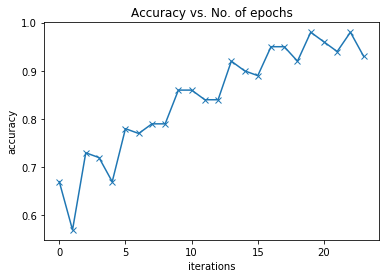

In [18]:
plot_accuracies(acc)

# Testing

In [64]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
check = nn.CrossEntropyLoss()
test_acc=[]
test_loss=[]
total = len(test_dataset)
with torch.no_grad():
    
    for i, (images, labels) in enumerate(test_set):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = check(outputs, labels)
        if (i+1) % yy == 0:
            a = accuracy(outputs, labels)
            test_acc.append(a)
            test_loss.append(loss)
    print('Test Accuracy: {:.2f}%, Loss: {:.2f}'.format(a*100, loss.item()))


Test Accuracy: 89.00%, Loss: 0.57


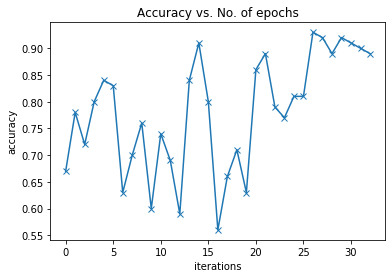

In [65]:
plot_accuracies(test_acc)


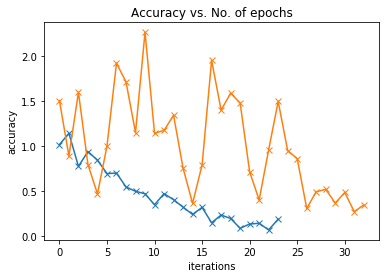

In [68]:
plot_accuracies(losses)
plt.plot(test_loss, '-x')

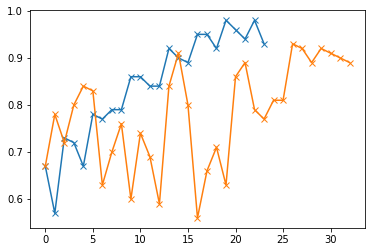

In [69]:
plt.plot(acc, '-x')
plt.plot(test_acc, '-x')

Initialy, both the training and validation losses seem to decrease over time. However, if you train the model for long enough, you will notice that the training loss continues to decrease, while the validation loss stops decreasing, and even starts to increase after a certain point!

This phenomenon is called **overfitting**, and it is the no. 1 why many machine learning models give rather terrible results on real-world data. It happens because the model, in an attempt to minimize the loss, starts to learn patters are are unique to the training data, sometimes even memorizing specific training examples. Because of this, the model does not generalize well to previously unseen data.